# Naive Bayes

In [156]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Enable python to import modules from parent directory
import sys
sys.path.append("..")

from src.config import *

# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None

In [2]:
data_path = os.path.join(DATA_CLEAN_PATH, "ml-curated-data.csv")
data = pd.read_csv(data_path, encoding='latin1')

In [3]:
data.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,state,gender,age,wage_increase
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,0.015672,0.01909,0.016816,0.075232
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,0.015672,0.01909,0.016816,-0.021322
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,0.015672,0.01909,0.016816,-0.023162
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,0.015672,0.01909,0.016816,-0.028393
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,0.015672,0.01909,0.016816,0.028896


In [4]:
naive_bayes = GaussianNB(var_smoothing=6)

In [5]:
naive_bayes

GaussianNB(priors=None, var_smoothing=6)

In [6]:
# take only 70 percent of data
train_data = data.sample(frac=0.7)

In [7]:
train_data_x = data.drop(columns=['wage_increase'])
train_data_x.head()

,lag_11,lag_7,lag_6,lag_3,lag_2,lag_1,state,gender,age
0,0.024181,-0.053836,-0.023294,-0.087671,0.059876,0.032627,0.015672,0.01909,0.016816
1,0.001615,-0.023294,-0.063004,0.059876,0.032627,0.075232,0.015672,0.01909,0.016816
2,0.002881,-0.063004,0.131306,0.032627,0.075232,-0.021322,0.015672,0.01909,0.016816
3,0.093041,0.131306,-0.087671,0.075232,-0.021322,-0.023162,0.015672,0.01909,0.016816
4,-0.053836,-0.087671,0.059876,-0.021322,-0.023162,-0.028393,0.015672,0.01909,0.016816


In [8]:
train_data_y = train_data['wage_increase']

In [9]:
type(train_data_y)

pandas.core.series.Series

In [10]:
# naive bayes cant detect data type
train_data_y = np.asarray(data['wage_increase'], dtype="|S9")

In [11]:
naive_bayes.fit(train_data_x, train_data_y)

GaussianNB(priors=None, var_smoothing=6)

In [12]:
predicted = pd.to_numeric(naive_bayes.predict([train_data_x.iloc[0]]))

In [13]:
expected = data.iloc[0]['wage_increase']
pd.to_numeric(expected)

0.07523202914031679

In [14]:
pd.to_numeric(predicted[0])

0.0226307

## Error distribution Naive Bayes

In [15]:
estimates_nb = naive_bayes.predict(train_data_x)

In [16]:
estimates_nb

array([b'0.0226307', b'-0.013410', b'-0.001977', ..., b'-0.105102',
       b'-0.018273', b'-0.013410'], dtype='|S12')

In [17]:
estimates_nb_numeric = pd.to_numeric(estimates_nb)

In [18]:
train_data_y_numeric = pd.to_numeric(train_data_y)

In [19]:
error_nb = np.asmatrix(train_data_y_numeric - estimates_nb_numeric)

In [20]:
error_nb

matrix([[ 0.0526013, -0.007912 , -0.021184 , ...,  0.002647 ,  0.1364204,
          0.0371726]])

In [21]:
sme_nb = (error_nb.T * error_nb / len(error_nb)).tolist()[0][0]

In [22]:
sme_nb

0.0027668967616900006

In [23]:
sme_nb = np.sqrt(sme_nb)

In [24]:
error_list = error_nb.tolist()

In [25]:
df_errors = pd.DataFrame({'error': [e for ls in error_nb.tolist() for e in ls]})

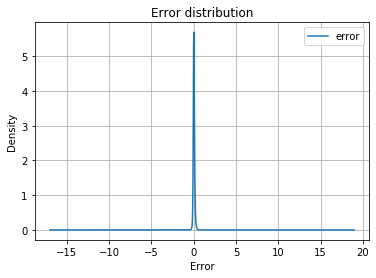

,error
count,1.126400e+06
mean,3.136487e+00
std,2.055004e+01
min,-8.015744e+02
25%,-1.226200e+00
50%,1.655195e+00
75%,6.927458e+00
max,9.968993e+02


In [26]:
df_errors.plot.kde()
plt.title("Error distribution")
plt.xlabel("Error")
plt.grid()
plt.show()

100 * df_errors.describe()

In [27]:
test = pd.DataFrame({
    "y": pd.to_numeric(train_data_y),
    "y_estimate": pd.to_numeric(estimates_nb)
})

In [28]:
test.describe()

,y,y_estimate
count,11264.000000,11264.000000
mean,0.018835,-0.012530
std,0.220504,0.085134
min,-8.029154,-6.686025
25%,-0.033226,-0.013410
50%,0.010558,-0.013410
75%,0.061343,-0.013410
max,9.955583,0.743607


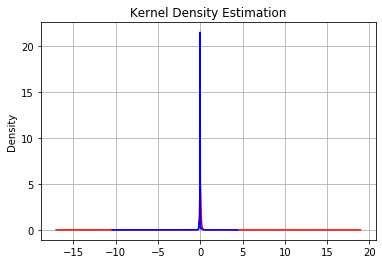

In [29]:
test.y.plot.kde(c='r')
test.y_estimate.plot.kde(c='b')
plt.title("Kernel Density Estimation")
plt.grid()
plt.show()

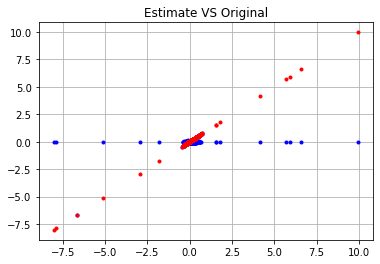

In [30]:
plt.plot(test.y, test.y_estimate, '.b')
plt.plot(test.y, test.y, '.r')
plt.title("Estimate VS Original")
plt.grid()
plt.show()

## Test multiple parametes

In [31]:
# GaussianNB(priors=None, var_smoothing=100)

In [32]:
import random

def get_random_params():
    return {
        'var_smoothing': random.choice((range(1, 500)))
    }

In [212]:
def perform_fit(df, var_smoothing):
    
    naive_bayes = GaussianNB(var_smoothing=var_smoothing)
    
    train = data.sample(frac=0.7)
    test = data.drop(train.index)
    
    train_x = train.drop(columns=['wage_increase'])
    train_y = train['wage_increase']
    
    test_x = test.drop(columns=['wage_increase'])
    test_y = test['wage_increase']
    
    train_data_y = np.asarray(train_y, dtype="|S9")  # change type
    naive_bayes.fit(train_x, train_data_y)
    
    estimates = naive_bayes.predict(train_x)
    
    train_data_y_numeric = pd.to_numeric(train_data_y)
    estimates_numeric = pd.to_numeric(estimates)
    
    # array_substract = np.subtract(train_data_y_numeric, estimates_numeric)
    error = np.asmatrix(train_data_y_numeric - estimates_numeric)
    sme = (error.T * error / len(error)).tolist()[0][0]
    rsme = np.sqrt(sme)
    
    return rsme

In [100]:
def get_error_and_params(df, loop_quantity):
    
    errors_and_params = []

    for i in range(1, loop_quantity):
        
        params = get_random_params()
        var_smoothing = params.get('var_smoothing')
        rsme = perform_fit(df, var_smoothing)
        error_and_param = {'var_smoothing': var_smoothing, 'rsme': rsme}
        errors_and_params.append(error_and_param)
    
    return errors_and_params

In [217]:
errors_and_params = get_error_and_params(data, 10)

In [218]:
errors_and_params

[{'var_smoothing': 5, 'rsme': 0.0452058},
 {'var_smoothing': 70, 'rsme': 0.097129},
 {'var_smoothing': 17, 'rsme': 0.10584380000000002},
 {'var_smoothing': 9, 'rsme': 0.0436969},
 {'var_smoothing': 26, 'rsme': 0.021857500000000002},
 {'var_smoothing': 57, 'rsme': 0.135015},
 {'var_smoothing': 99, 'rsme': 0.045181},
 {'var_smoothing': 16, 'rsme': 0.09974930000000001},
 {'var_smoothing': 42, 'rsme': 0.095851}]

In [219]:
df_errors_and_params = pd.DataFrame(errors_and_params)

In [220]:
df_errors_and_params

,var_smoothing,rsme
0,5,0.045206
1,70,0.097129
2,17,0.105844
3,9,0.043697
4,26,0.021858
5,57,0.135015
6,99,0.045181
7,16,0.099749
8,42,0.095851


In [221]:
rsmes = df_errors_and_params['rsme']

In [222]:
rsme = min(i for i in rsmes)
df_param_rsme = df_errors_and_params[df_errors_and_params.rsme == rsme]
df_param_rsme

,var_smoothing,rsme
4,26,0.021858


In [223]:
X = data.drop('wage_increase', axis=1)
y = data['wage_increase']

x_train, y_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [225]:
naive_bayes = GaussianNB(var_smoothing=df_param_rsme['rsme'])

In [226]:
naive_bayes

GaussianNB(priors=None, var_smoothing=4    0.021858
Name: rsme, dtype: float64)

In [227]:
train_data_y = np.asarray(train_y, dtype="|S9")  # change type
naive_bayes.fit(train_x, train_data_y)

GaussianNB(priors=None, var_smoothing=4    0.021858
Name: rsme, dtype: float64)

In [228]:
estimates = pd.to_numeric(naive_bayes.predict(train_x))

In [229]:
test_estimates =  pd.to_numeric(naive_bayes.predict(test_x))

In [230]:
len(estimates)

7885

In [231]:
len(test_estimates)

7885

In [232]:
real_test = pd.DataFrame({'estimates': estimates, 'test_estimates': test_estimates})

In [233]:
real_test

,estimates,test_estimates
0,0.016277,0.121529
1,-0.033255,-0.004227
2,0.002373,0.110129
3,-0.065358,-0.026758
4,0.172439,-0.112207
...,...,...
7880,0.026902,-0.007908
7881,0.099238,0.054595
7882,0.049588,-0.055052
7883,-0.091056,-0.042587


In [234]:
error = np.asmatrix(test_estimates - estimates)
sme = (error.T * error / len(error)).tolist()[0][0]
sme

0.01107792035289

In [235]:
np.sqrt(sme)

0.1052517

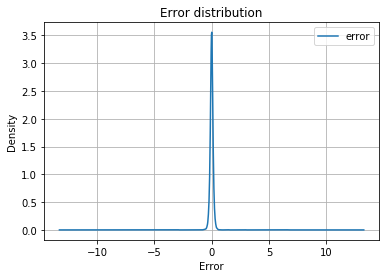

In [236]:
df_errors = pd.DataFrame({'error': [e for ls in error.tolist() for e in ls]})
df_errors.plot.kde()
plt.title("Error distribution")
plt.xlabel("Error")
plt.grid()
plt.show()

In [237]:
test_results = pd.DataFrame(
    {
    "y": estimates,
    "y_estimate": test_estimates
    }
)

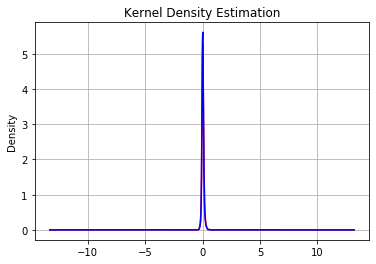

In [238]:
test_results.y.plot.kde(c='r')
test_results.y_estimate.plot.kde(c='b')
plt.title("Kernel Density Estimation")
plt.grid()
plt.show()

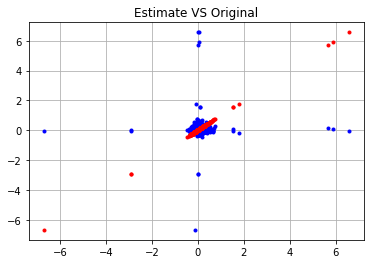

In [239]:
plt.plot(test_results.y, test_results.y_estimate, '.b')
plt.plot(test_results.y, test_results.y, '.r')
plt.title("Estimate VS Original")
plt.grid()
plt.show()

In [ ]:
# all_estimates = np.array(estimates_array).flatten()

In [ ]:
estimates_array[0]

In [ ]:
len(all_estimates)

In [ ]:
np.unique(all_estimates)

In [ ]:
all_estimates

In [ ]:
pd.to_numeric(train_y)

In [ ]:
df_errors_sqrt = pd.DataFrame({
    'var_smoothing': var_smoothing_array,
    'error': error_array 
})

In [ ]:
df_errors_sqrt.min()

In [ ]:
# df_errors_sqrt.to_csv('errors.csv')

In [ ]:
estimates = estimates_array[0]
estimates.tolist()

In [ ]:
test_results = pd.DataFrame(
    {
        "y": train_y,
        "y_estimate": estimates
    }
)

In [ ]:
plt.plot(test_results.y, test_results.y_estimate, '.b')
plt.plot(test_results.y, test_results.y, '.r')
plt.title("Estimate VS Original")
plt.grid()
plt.show()

In [ ]:
df_errors_sqrt.plot.kde()
plt.title("Error distribution")
plt.xlabel("Error")
plt.grid()
plt.show()